# Analisis Data

In [22]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from pymongo import MongoClient
from dotenv import load_dotenv
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from imblearn.over_sampling import SMOTE


## Deklarasi variabel dan .env

In [23]:
# Nama database dan collection
db_name = 'youtube_rewind_indonesia'
full_labeling_all_collection_name = "full_labeling_all_new"
data_train_collection_name = "data_training_new"
data_test_collection_name = "data_testing_new"

# Memuat value dari file .env
load_dotenv()

mongodb_url = os.getenv('URL_SANDY')
local_url = os.getenv('URL_LOCAL')

## Membuat koneksi ke MongoDB

In [24]:
client = MongoClient(local_url)
db = client[db_name]
data_train_collection = db[data_train_collection_name]
data_test_collection = db[data_test_collection_name]
labeling_all_collection = db[full_labeling_all_collection_name]

# Mengambil data dari koleksi MongoDB
data_train = list(data_train_collection.find())
data_test = list(data_test_collection.find())
data_all = list(labeling_all_collection.find())

df_train = pd.DataFrame(data_train)
df_test = pd.DataFrame(data_test)
df_all = pd.DataFrame(data_all)

## Train model dengan Naive Bayes 

In [29]:
# Misalkan df_train dan df_test sudah didefinisikan sebelumnya
# Memisahkan fitur dan label dari data training dan testing
X_train = df_train['afterNormalisasi']
y_train = df_train['label']
X_test = df_test['afterNormalisasi']
y_test = df_test['label']

# Menggunakan TfidfVectorizer untuk mengubah teks menjadi fitur
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Menggunakan SMOTE untuk melakukan oversampling pada data latih
smote = SMOTE(random_state=42)
X_train_tfidf_res, y_train_res = smote.fit_resample(X_train_tfidf, y_train)

# Melatih model menggunakan data train yang telah di-oversample
model = MultinomialNB()
model.fit(X_train_tfidf_res, y_train_res)

# Memprediksi data test
y_test_pred = model.predict(X_test_tfidf)

# Menghitung akurasi
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Akurasi model: {accuracy}")

# Mencetak classification report
report = classification_report(y_test, y_test_pred)
print(f"Classification Report:\n{report}")

# Menyimpan model dan vectorizer
joblib.dump(model, 'model_nb.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')

print("Model dan vectorizer telah disimpan.")

Akurasi model: 0.8558558558558559
Classification Report:
              precision    recall  f1-score   support

     negatif       0.87      0.87      0.87       333
      netral       0.86      0.76      0.81       333
     positif       0.85      0.93      0.89       333

    accuracy                           0.86       999
   macro avg       0.86      0.86      0.85       999
weighted avg       0.86      0.86      0.85       999

Model dan vectorizer telah disimpan.


# Predicted Label All Data From Model

In [30]:
# Mengambil data yang belum memiliki label dari koleksi MongoDB
data_unlabeled = list(labeling_all_collection.find())

# Membuat DataFrame dari data yang belum memiliki label
df_unlabeled = pd.DataFrame(data_unlabeled)

# Menggunakan vectorizer yang sama seperti yang digunakan untuk training
X_unlabeled = vectorizer.transform(df_unlabeled['textOriginal'])

# Melakukan prediksi label untuk data yang belum memiliki label
y_pred_unlabeled = model.predict(X_unlabeled)

# Menambahkan hasil prediksi label ke dalam koleksi MongoDB
for idx, doc in enumerate(data_unlabeled):
    predicted_label = y_pred_unlabeled[idx]
    labeling_all_collection.update_one({"_id": doc["_id"]}, {"$set": {"predicted_label": predicted_label}})

print("Labeling proses selesai.")


Labeling proses selesai.


# Mengidentifikasi Topik Dengan Latent Dirichlet Allocation (LDA).

In [6]:
# Memisahkan komentar positif dan negatif
df_positive = df_all[df_all['predicted_label'] == 'positif']
df_negative = df_all[df_all['predicted_label'] == 'negatif']
df_netral = df_all[df_all['predicted_label'] == 'netral']

def lda_topic_modeling(texts, n_topics=5, n_words=5):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(texts)
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(X)
    words = vectorizer.get_feature_names_out()
    topics = []
    for idx, topic in enumerate(lda.components_):
        topics.append([words[i] for i in topic.argsort()[:-n_words - 1:-1]])
    return topics

# Ekstraksi topik dari komentar positif
positive_topics = lda_topic_modeling(df_positive['textOriginal'], n_topics=1, n_words=5)
print("Topik dalam komentar positif:")
for i, topic in enumerate(positive_topics):
    print(f"Topik {i + 1}: {', '.join(topic)}")

# Ekstraksi topik dari komentar negatif
negative_topics = lda_topic_modeling(df_negative['textOriginal'], n_topics=1, n_words=5)
print("\nTopik dalam komentar negatif:")
for i, topic in enumerate(negative_topics):
    print(f"Topik {i + 1}: {', '.join(topic)}")

# Ekstraksi topik dari komentar netral
netral_topics = lda_topic_modeling(df_netral['textOriginal'], n_topics=1, n_words=5)
print("\nTopik dalam komentar netral:")
for i, topic in enumerate(netral_topics):
    print(f"Topik {i + 1}: {', '.join(topic)}")


Topik dalam komentar positif:
Topik 1: keren, banget, indonesia, rewind, bagus

Topik dalam komentar negatif:
Topik 1: tidak, rewind, youtube, yah, nya

Topik dalam komentar netral:
Topik 1: rewind, tonton, youtube, apa, lagu


# Memprediksi Jumlah Kata Pada Komentar

In [7]:
import os
import pandas as pd
from pymongo import MongoClient
from dotenv import load_dotenv
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

# Nama database dan collection
db_name = 'youtube_rewind_indonesia'
collection_name = 'full_labeling_all_new'

# Memuat value dari file .env
load_dotenv()

mongodb_url = os.getenv('URL_SANDY')
local_url = os.getenv('URL_LOCAL')

# Membuat koneksi ke MongoDB
client = MongoClient(local_url)
db = client[db_name]
preprocessing_data = db[collection_name]

# Mengambil data dari koleksi MongoDB
data = list(preprocessing_data.find())

# Konversi data menjadi dataframe
df = pd.DataFrame(data)

# Menghitung panjang komentar dalam jumlah kata dan karakter
df['comment_length'] = df['textOriginal'].apply(lambda x: len(x.split()))
df['char_count'] = df['textOriginal'].apply(lambda x: len(x))

# Mengubah kolom 'publishedAt' menjadi timezone-aware datetime
df['publishedAt'] = pd.to_datetime(df['publishedAt']).dt.tz_localize(None)

# Menghitung waktu sejak komentar diposting dalam detik
current_time = pd.Timestamp.now().tz_localize(None)
df['time_since_posted'] = (current_time - df['publishedAt']).dt.total_seconds()

# Mengisi nilai NaN dengan 0 untuk likeCount
df['likeCount'] = df['likeCount'].fillna(0).astype(int)

# Mengonversi predicted_label menjadi dummy variables
df = pd.get_dummies(df, columns=['predicted_label'], drop_first=True)

# Menambahkan panjang teks asli sebagai fitur
df['textOriginal_length'] = df['textOriginal'].apply(len)

# Mendefinisikan variabel independen dan dependen
features = ['likeCount', 'time_since_posted', 'char_count', 'textOriginal_length'] + [col for col in df.columns if 'predicted_label_' in col]
X = df[features]
y = df['comment_length']

# Membagi data menjadi training dan testing set
X_train, X_test, y_training, y_testing = train_test_split(X, y, test_size=0.2, random_state=42)

# Membangun model Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Hyperparameter tuning menggunakan GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_training)

# Model terbaik setelah GridSearchCV
best_rf = grid_search.best_estimator_

# Prediksi jumlah kata pada data testing
y_pred = best_rf.predict(X_test)

# Melihat hasil prediksi vs nilai aktual
results = pd.DataFrame({'Actual': y_testing, 'Predicted': y_pred})
print(results.head(10))

# Menghitung RMSE
rmse = np.sqrt(mean_squared_error(y_testing, y_pred))
print(f'Root Mean Squared Error: {rmse}')


Fitting 3 folds for each of 108 candidates, totalling 324 fits
       Actual  Predicted
12628      19  20.998478
37730       6   5.740600
39991       5   3.894771
8525        8   8.817663
8279       11  11.175188
51012      17  14.254375
14871      16  16.332944
15127      16  20.359730
9366        3   2.937785
33322       2   2.525710
Root Mean Squared Error: 2.111079071596731


# Visualisasi Data Pembuatan Model Machine Learning

## Scatter Plot Actual vs Predicted:

Visualisasi ini menunjukkan hubungan antara nilai panjang komentar yang sebenarnya (actual) dengan yang diprediksi oleh model (predicted). Garis merah putus-putus menunjukkan garis ideal di mana prediksi sama dengan nilai aktual. Semakin dekat titik-titik ini ke garis, semakin baik kinerja model.

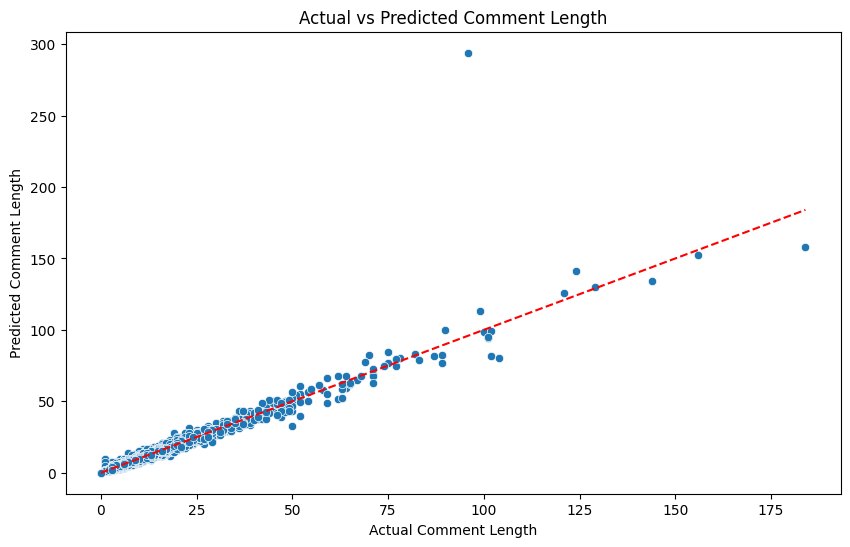

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual', y='Predicted', data=results)
plt.plot([results['Actual'].min(), results['Actual'].max()], 
         [results['Actual'].min(), results['Actual'].max()], 
         color='red', linestyle='--')
plt.xlabel('Actual Comment Length')
plt.ylabel('Predicted Comment Length')
plt.title('Actual vs Predicted Comment Length')
plt.show()


## Residual Plot:

Plot ini menunjukkan residual (selisih antara nilai aktual dan prediksi) untuk setiap data point. Residual yang tersebar secara acak di sekitar garis horizontal pada 0 menunjukkan model yang baik tanpa pola sistematik dalam kesalahan prediksi.

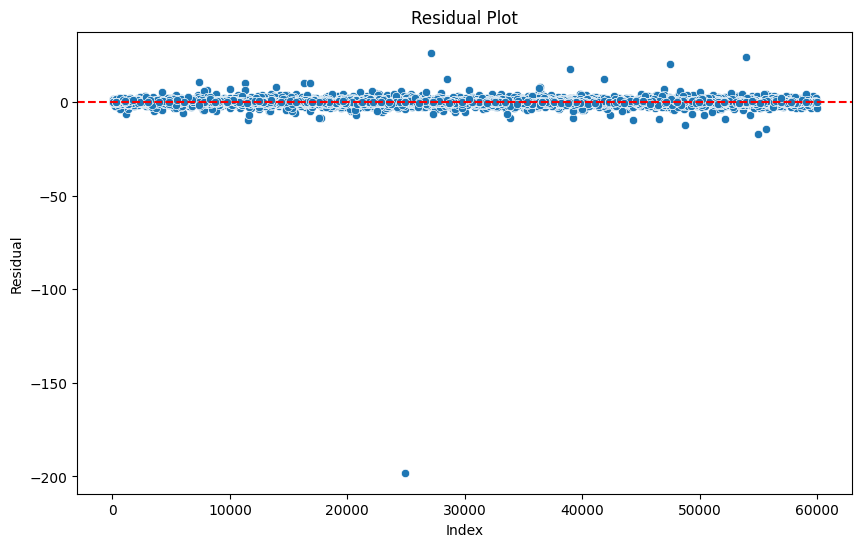

In [9]:
# Calculate residuals
results['Residual'] = results['Actual'] - results['Predicted']

# Residual Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=results.index, y='Residual', data=results)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Residual')
plt.title('Residual Plot')
plt.show()


## Histogram of Residuals:

Plot ini menunjukkan residual (selisih antara nilai aktual dan prediksi) untuk setiap data point. Residual yang tersebar secara acak di sekitar garis horizontal pada 0 menunjukkan model yang baik tanpa pola sistematik dalam kesalahan prediksi.

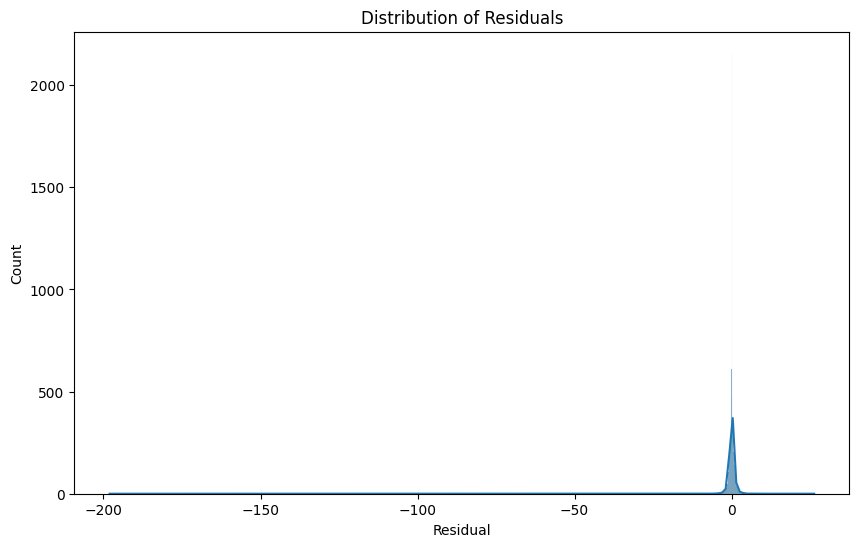

In [10]:
# Histogram of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(results['Residual'], kde=True)
plt.xlabel('Residual')
plt.title('Distribution of Residuals')
plt.show()


## Feature Importance Plot

Plot ini menunjukkan pentingnya setiap fitur dalam membuat prediksi. Fitur dengan pentingnya yang lebih tinggi memiliki pengaruh yang lebih besar dalam model prediksi. Visualisasi ini membantu memahami kontribusi setiap fitur terhadap prediksi model.

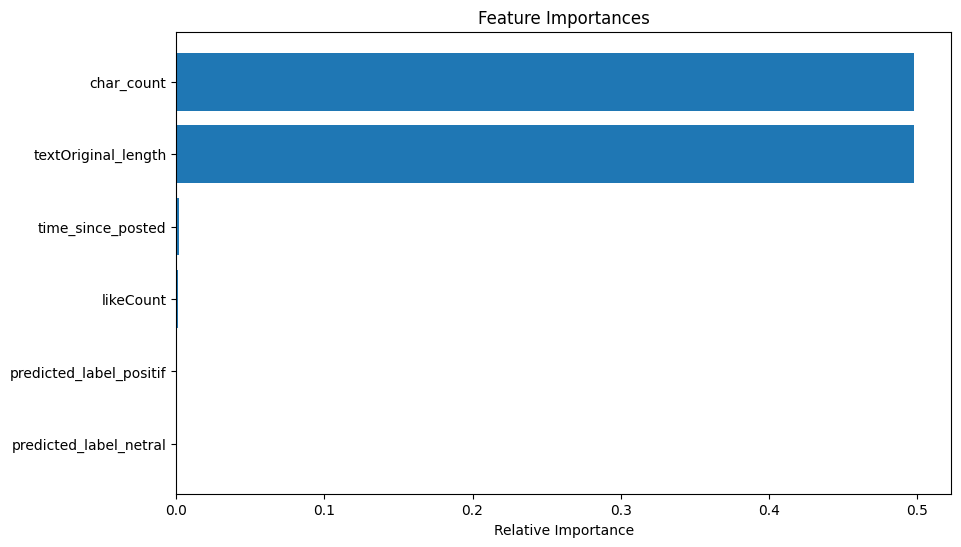

In [11]:
# Feature Importance Plot
importances = best_rf.feature_importances_
features = X.columns
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


## Confusion Matrix

Menunjukkan performa model dalam bentuk matriks kesalahan.

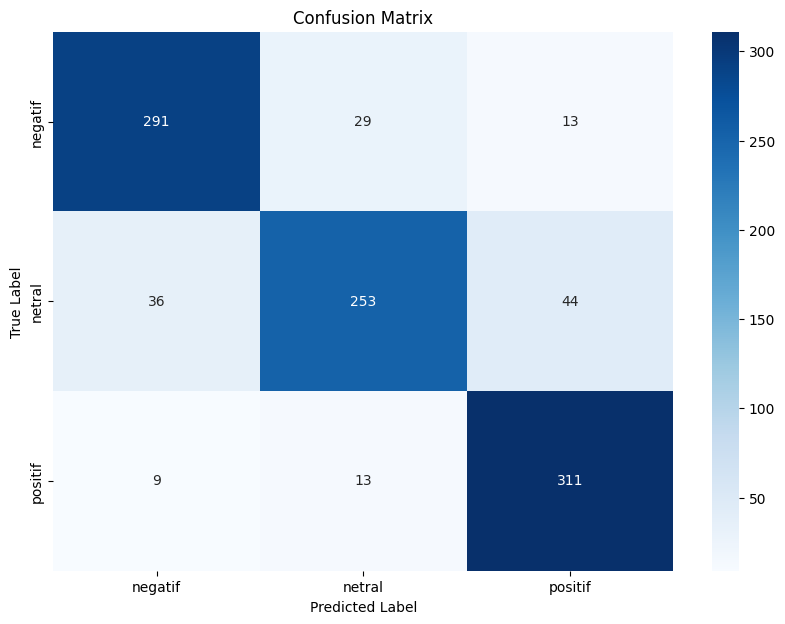

In [31]:
conf_matrix = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


## Bar Chart dari Prediksi

Menghitung jumlah prediksi untuk setiap label

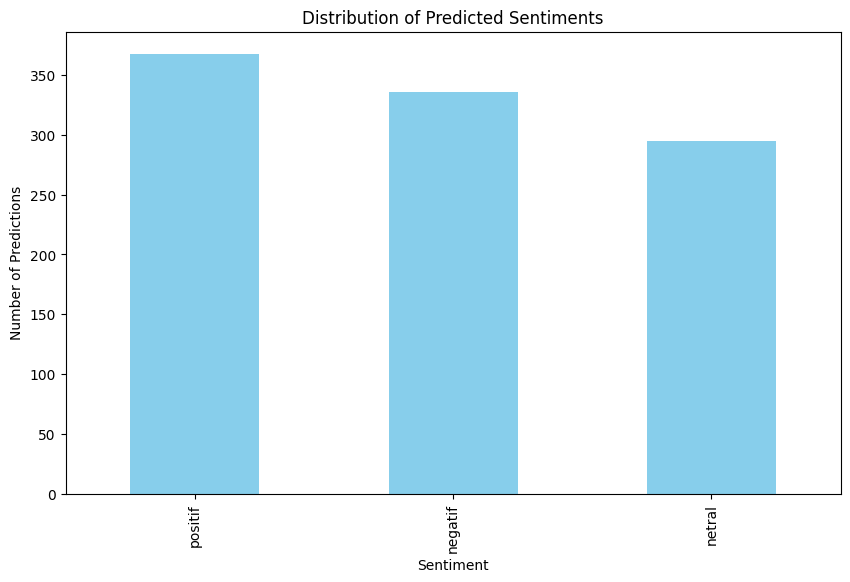

In [32]:
# Menghitung jumlah prediksi untuk setiap label
pred_counts = pd.Series(y_test_pred).value_counts()

# Plot Bar Chart
plt.figure(figsize=(10, 6))
pred_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Sentiment')
plt.ylabel('Number of Predictions')
plt.title('Distribution of Predicted Sentiments')
plt.show()


## ROC Curve dan AUC

ROC (Receiver Operating Characteristic) dan AUC (Area Under the Curve) adalah metrik yang digunakan untuk mengevaluasi kinerja model klasifikasi, terutama dalam konteks klasifikasi biner, tetapi juga dapat diterapkan pada multi-kelas dengan teknik tertentu.

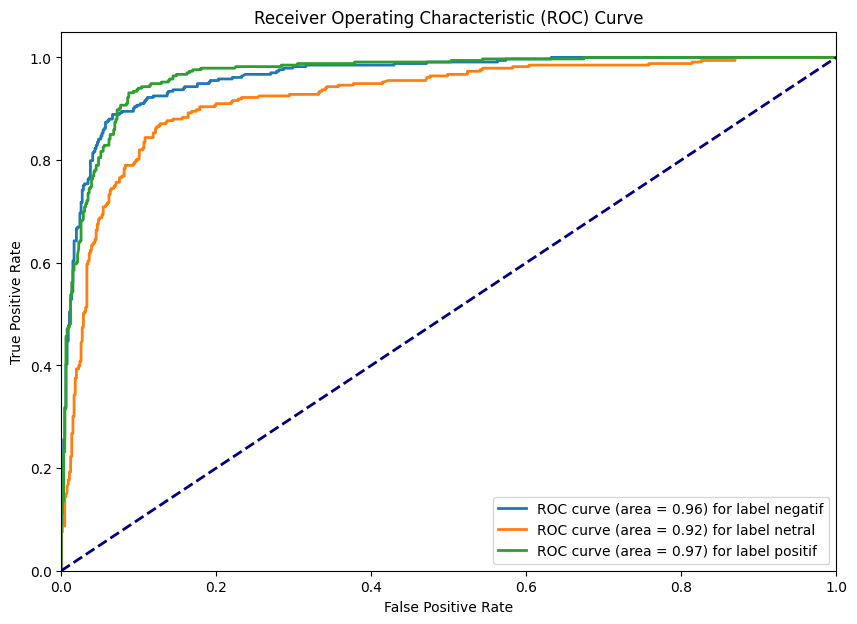

In [33]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test_binarized = label_binarize(y_test, classes=model.classes_)
y_pred_proba = model.predict_proba(X_test_tfidf)

# Plot ROC Curve
plt.figure(figsize=(10, 7))
for i, label in enumerate(model.classes_):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f}) for label {label}')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


## Calculate text lengths

Visualisasi distribusi panjang teks dalam data latih dan uji.

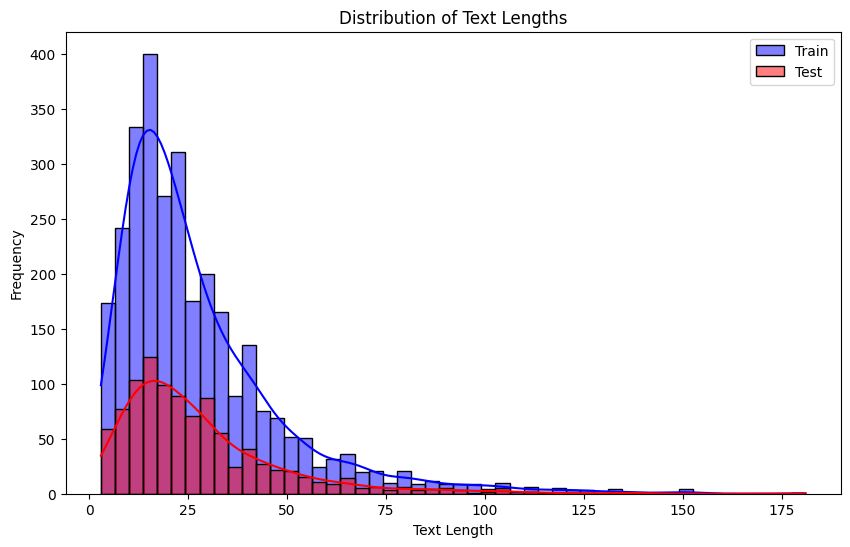

In [34]:
df_train['text_length'] = df_train['textOriginal'].apply(len)
df_test['text_length'] = df_test['textOriginal'].apply(len)

# Plot text length distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_train['text_length'], bins=50, color='blue', label='Train', kde=True)
sns.histplot(df_test['text_length'], bins=50, color='red', label='Test', kde=True)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.legend()
plt.show()


## Word Cloud Data Training

Menampilkan kata-kata yang paling sering muncul dalam teks berdasarkan sentimen.

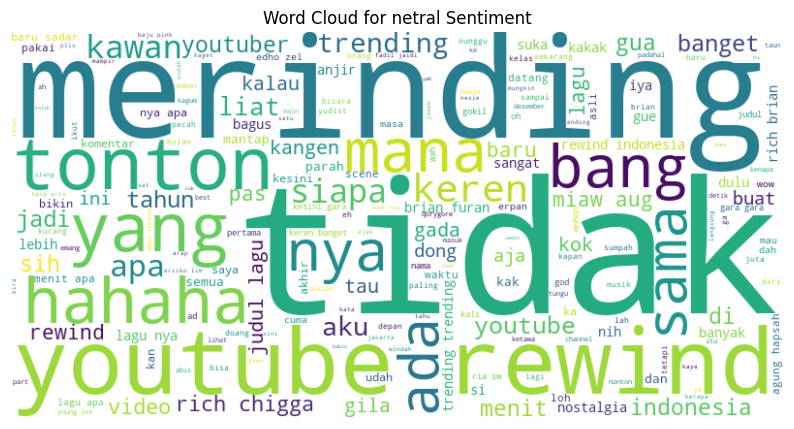

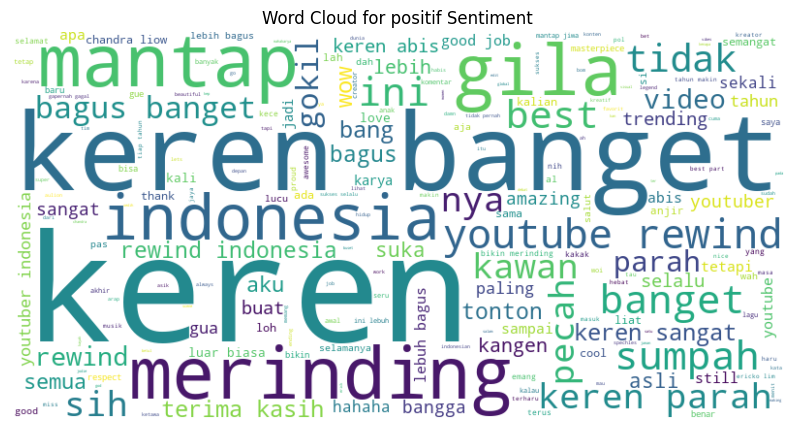

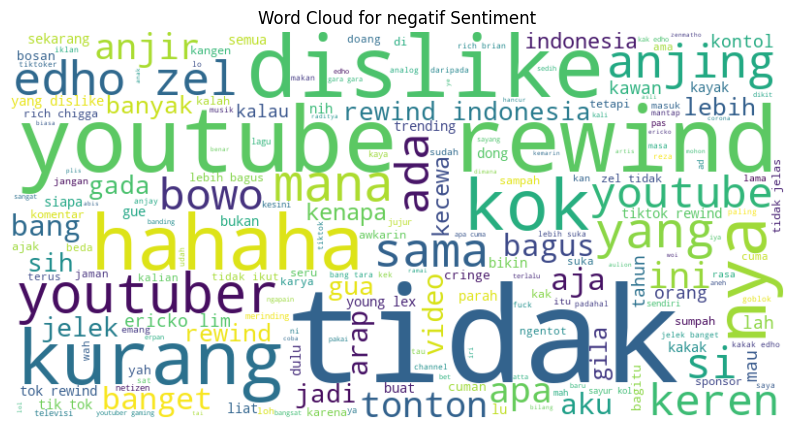

In [35]:
from wordcloud import WordCloud

# Generate word cloud for each sentiment
sentiments = ['netral', 'positif', 'negatif']
for sentiment in sentiments:
    text = ' '.join(df_train[df_train['label'] == sentiment]['textOriginal'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {sentiment} Sentiment')
    plt.axis('off')
    plt.show()


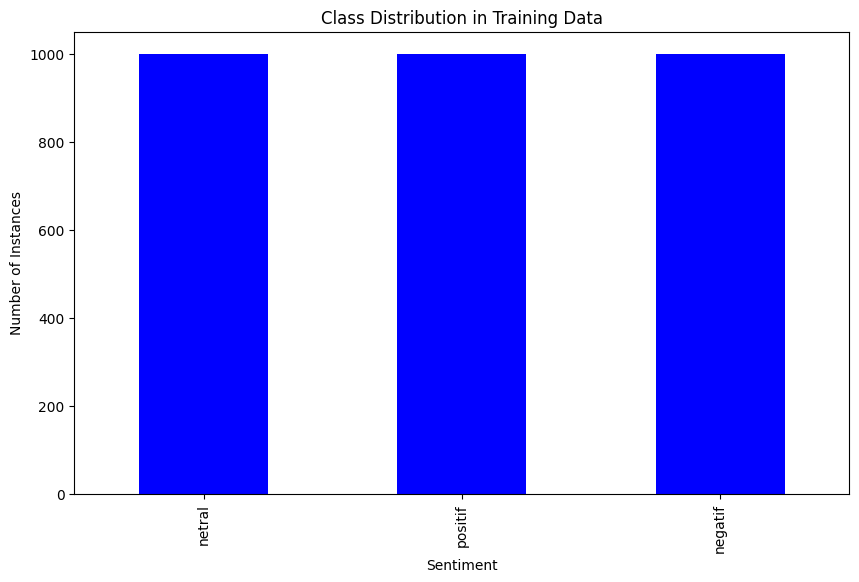

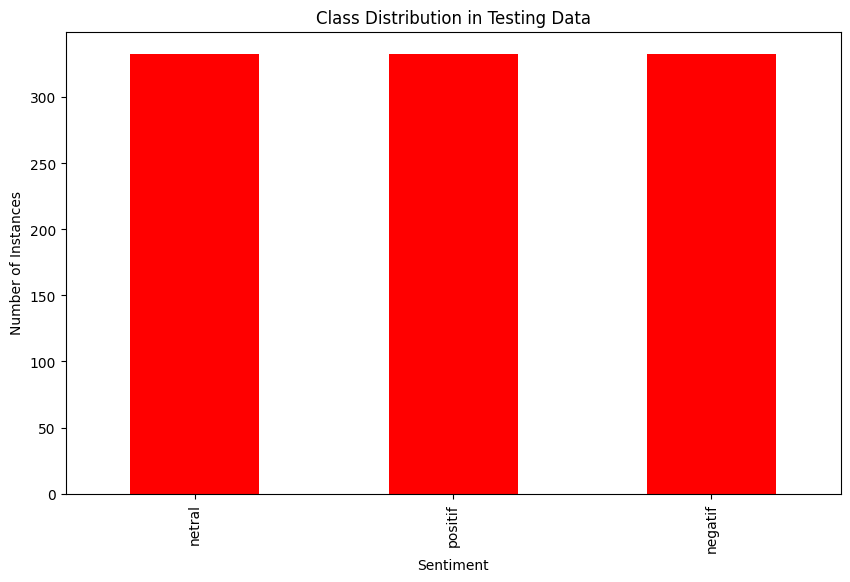

In [36]:
# Plot class distribution in training data
plt.figure(figsize=(10, 6))
df_train['label'].value_counts().plot(kind='bar', color='blue')
plt.xlabel('Sentiment')
plt.ylabel('Number of Instances')
plt.title('Class Distribution in Training Data')
plt.show()

# Plot class distribution in testing data
plt.figure(figsize=(10, 6))
df_test['label'].value_counts().plot(kind='bar', color='red')
plt.xlabel('Sentiment')
plt.ylabel('Number of Instances')
plt.title('Class Distribution in Testing Data')
plt.show()


## Learning Curve

Learning curve membantu memahami performa model berdasarkan ukuran data pelatihan.

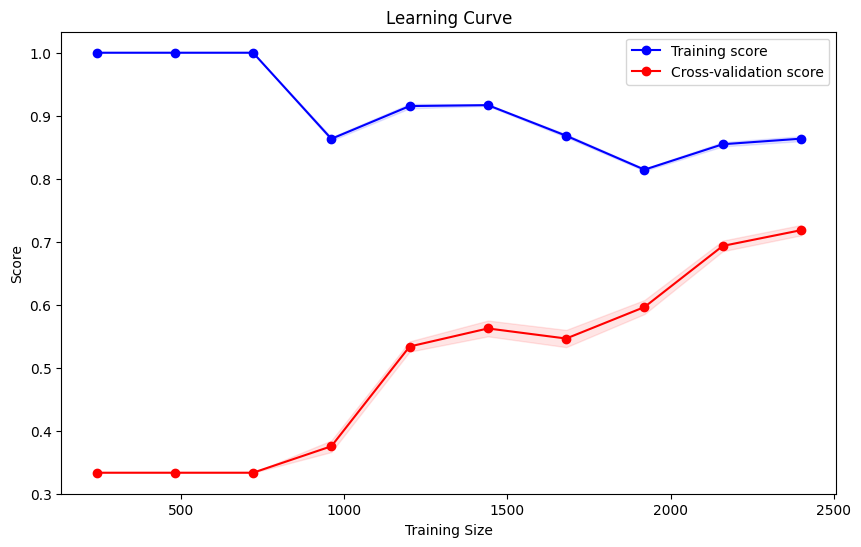

In [37]:
from sklearn.model_selection import learning_curve

# Learning curve
train_sizes, train_scores, test_scores = learning_curve(model, X_train_tfidf, y_train_res, cv=5, n_jobs=-1, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10), 
                                                        scoring='accuracy')

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='red', label='Cross-validation score')

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='red', alpha=0.1)

plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.show()


## Histogram distribusi probabilitas dari prediksi model

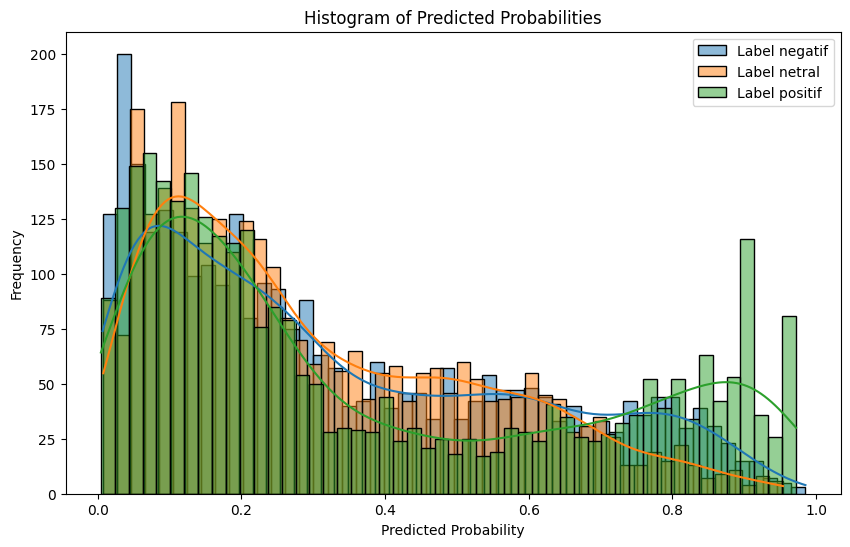

In [38]:
# Probabilities of the predictions
y_pred_proba = model.predict_proba(X_train_tfidf)

plt.figure(figsize=(10, 6))
for i, label in enumerate(model.classes_):
    sns.histplot(y_pred_proba[:, i], bins=50, kde=True, label=f'Label {label}')
    
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities')
plt.legend()
plt.show()


## Error Analysis

Menampilkan beberapa contoh teks yang salah diklasifikasikan oleh model.

In [39]:
# Adding predictions to the dataframe
df_test['predicted_label'] = y_test_pred

# Filtering the misclassified examples
misclassified = df_test[df_test['label'] != df_test['predicted_label']]

# Display some misclassified examples
print("Misclassified examples:")
print(f"Jumlah: {len(misclassified)}")
print(misclassified[['textOriginal', 'label', 'predicted_label']].head(10))

Misclassified examples:
Jumlah: 144
                                         textOriginal   label predicted_label
2                   pecah tahun sekarang goals banget  netral         positif
7                                    kawan caur parah  netral         positif
10                               kakak edho zel tidak  netral         negatif
14           lebih bagus daripada tiktok rewind keren  netral         negatif
18                             keren merinding tonton  netral         positif
19                                     merinding asli  netral         positif
25  gempak sial paling mantap part pertahankan tup...  netral         positif
27                        tidak kuat merinding banget  netral         positif
30                                   jerome kece abis  netral         positif
38                                    vngnc tidak why  netral         negatif


## Kata-Kata yang Paling Berpengaruh untuk Setiap Kelas

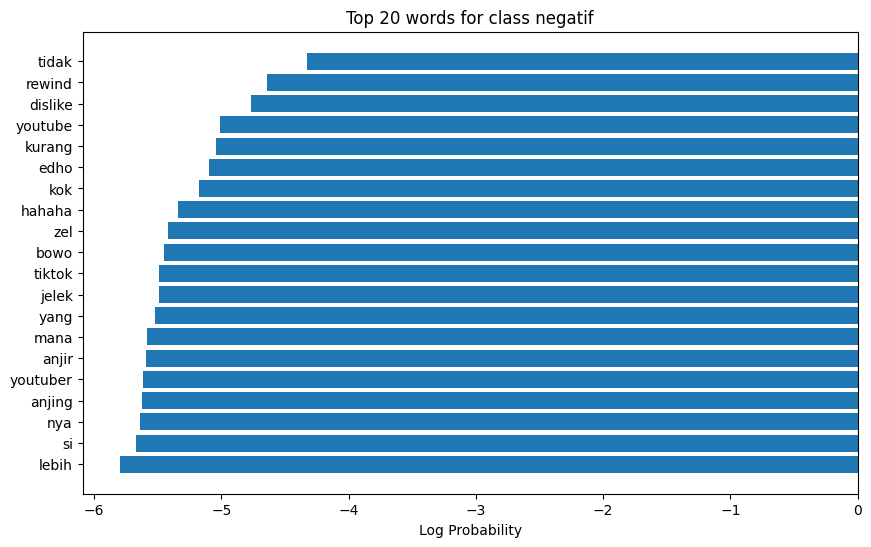

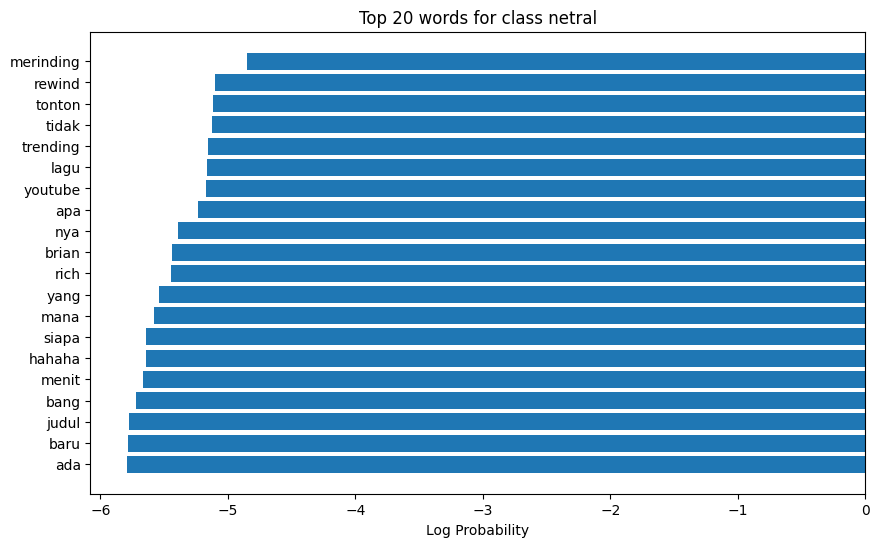

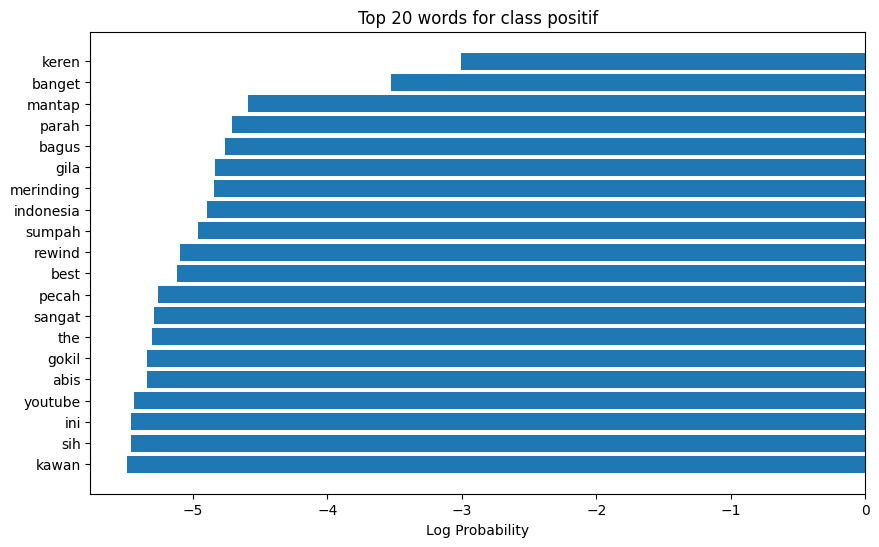

In [40]:
import numpy as np

# Extracting feature log probabilities
feature_log_prob = model.feature_log_prob_

# Extracting feature names
feature_names = vectorizer.get_feature_names_out()

# Function to plot top words
def plot_top_words(classifier, feature_names, class_labels, n_top_words=20):
    for i, class_label in enumerate(class_labels):
        top_features = np.argsort(classifier[i])[-n_top_words:]
        plt.figure(figsize=(10, 6))
        plt.barh(range(n_top_words), classifier[i][top_features], align='center')
        plt.yticks(np.arange(n_top_words), [feature_names[j] for j in top_features])
        plt.xlabel('Log Probability')
        plt.title(f'Top {n_top_words} words for class {class_label}')
        plt.show()

# Plot top words for each class
plot_top_words(feature_log_prob, feature_names, model.classes_)
